SnowCV method to quantify snow height from phenocam staff gauge imagery.
For NEON Battelle
Donal O'Leary
April 12 2021

Borrowing liberally from <a href="https://www.pyimagesearch.com/2017/07/17/credit-card-ocr-with-opencv-and-python/" target="_blank">this awesome tutorial by Adrian Rosebrock</a>.

In [1]:
import cv2
import imutils
from imutils import contours
import argparse
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Working with an Example Phenocam Image
For this next section, we will work with a single phenocam image to see if we can identify the digits that are on the staff gauge.

In [2]:
plt.rcParams['figure.figsize'] = [15, 15] # set plot size

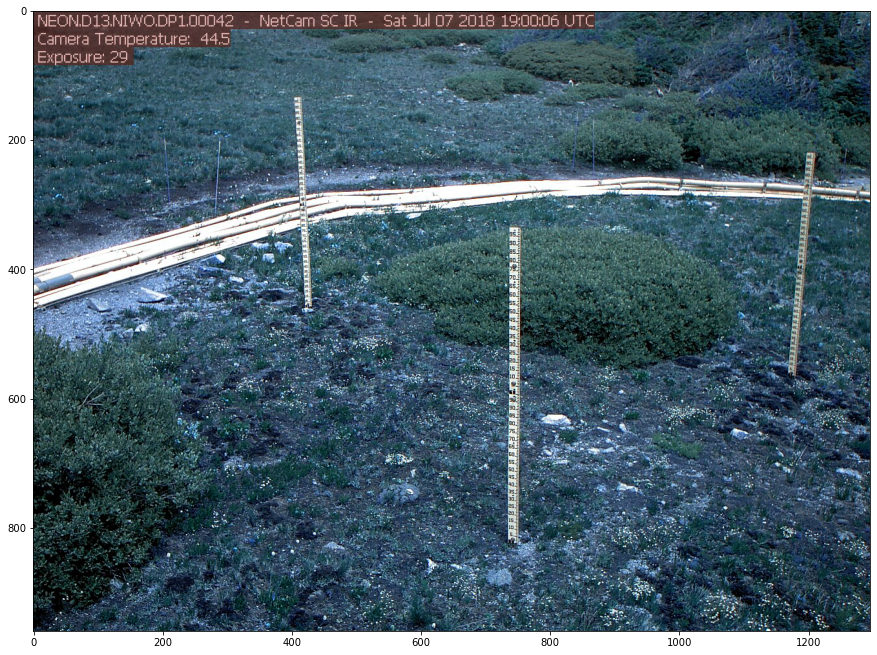

In [37]:
cal = cv2.imread('/Users/olearyd/Git/SnowCV/data/NIWO_gauge_calibration_bare_ground.jpg')
plt.imshow(cal)

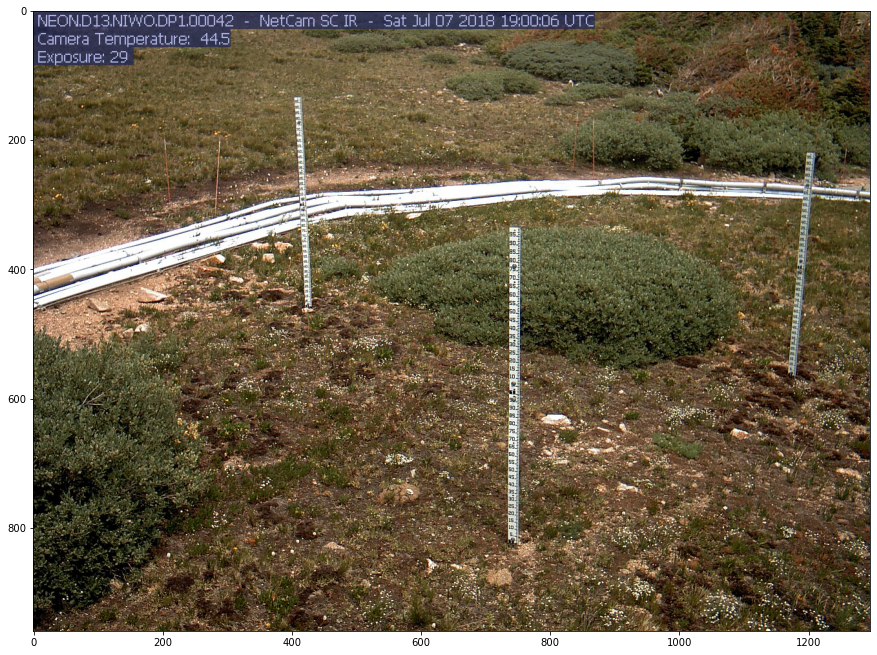

In [38]:
cal = cv2.cvtColor(cal, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(cal)

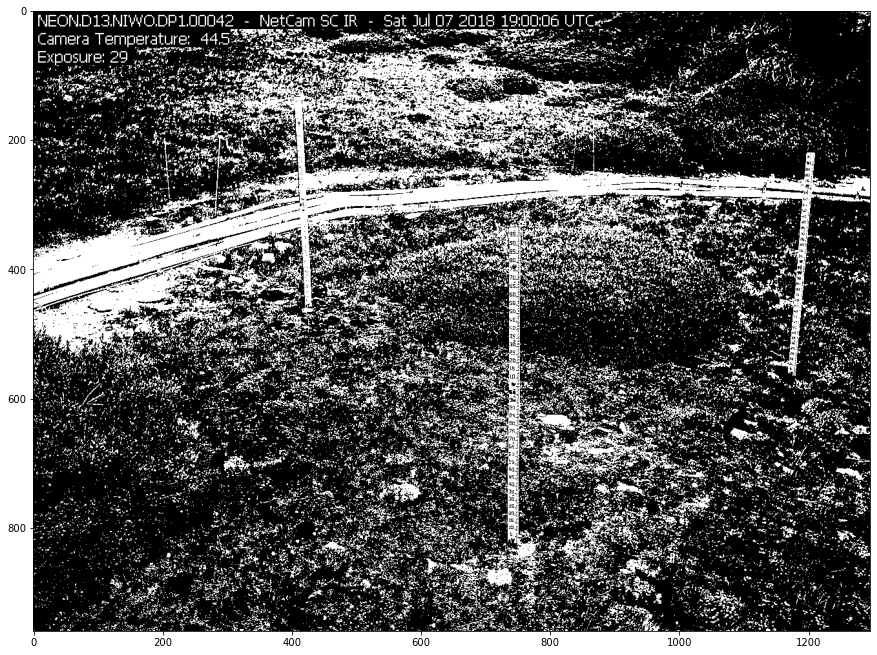

In [39]:
cal = cv2.cvtColor(cal, cv2.COLOR_RGB2GRAY)
cal = cv2.threshold(cal, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(cal, cmap='gray')

Now we must make a very precise bounding box around the staff gauge - this will be our 'ground truth' staff gauge length representing of zero snow.

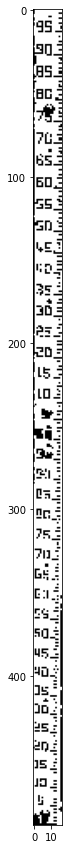

In [48]:
cal_gauge = cal[335:825,736:753]
plt.imshow(cal_gauge, cmap='gray')

In [69]:
gauge_height = cal_gauge.shape[0] # height in pixels
gauge_height

490

According to this image, the staff gauge has 490 visible pixels across its 2m height. We will use this to compare against subsequent images to deterrmine how deep the snow is!

## Working with a snowy Phenocam Image

In [ ]:
## Update this to grob all files from direectory
fn = '/Users/olearyd/Git/SnowCV/data/NEON.D13.NIWO.DP1.00042_2018_04_07_120006.jpg'

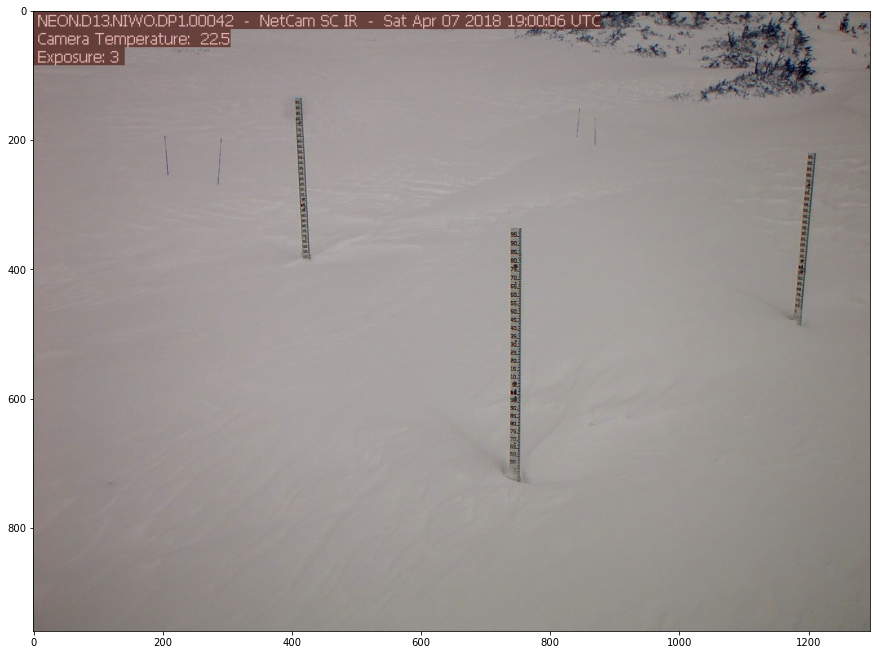

In [54]:
ref = cv2.imread(fn)
plt.rcParams['figure.figsize'] = [15, 15] # set plot size
plt.imshow(ref)

However, there is a problem here! The blue and red channels are reversed because `cv2.imread()` uses BGR as the default, whereas .jpg files are written in RGB order. So we can rearrange the channels and plot again.

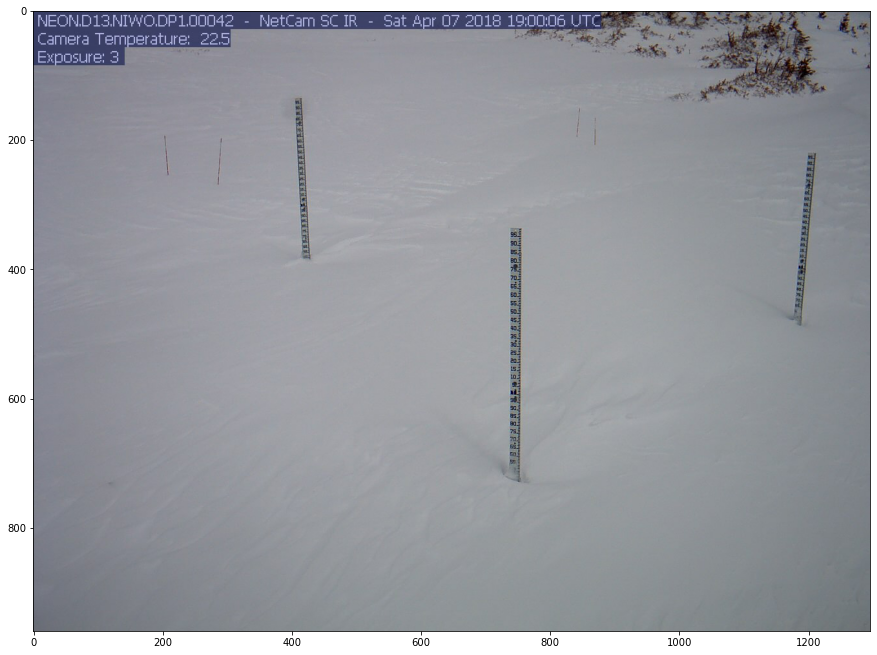

In [55]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(ref)

In any case, it is best practice to convert the three-color-channel image to a grayscale image for further processing. So we will convert this RGB image to Gray using the `cv2.cvtColor()` function with the `cv2.COLOR_RGB2GRAY` argument.

In [56]:

ref = cv2.cvtColor(ref, cv2.COLOR_RGB2GRAY)
ref = cv2.threshold(ref, 50, 255, cv2.THRESH_BINARY)[1]
ref

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

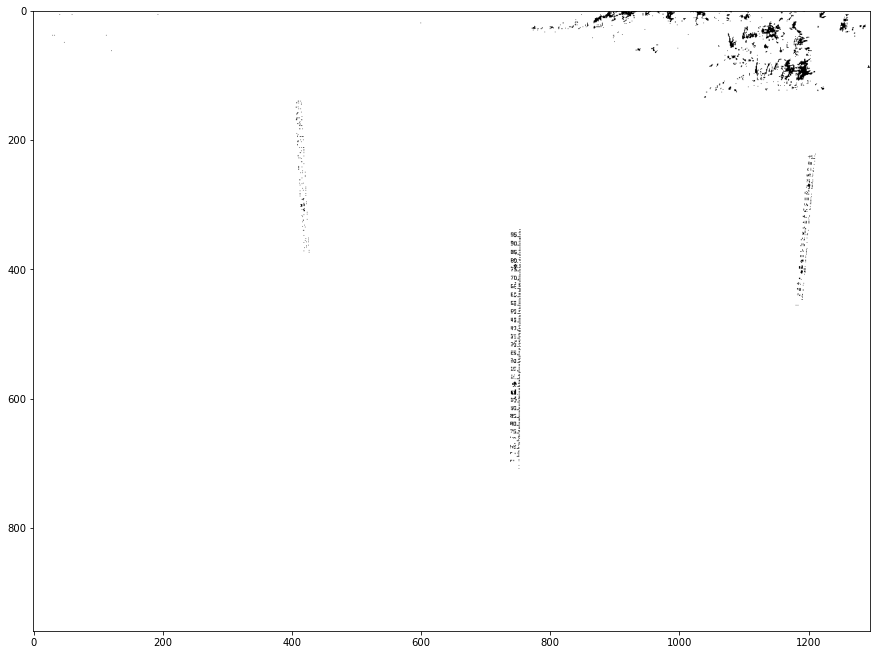

In [57]:
plt.imshow(ref, cmap='gray')

In [60]:
ROI = ref[335:825,735:755]

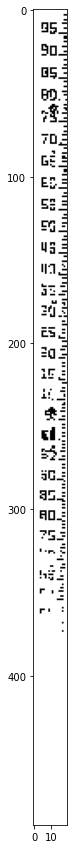

In [61]:
plt.rcParams['figure.figsize'] = [5, 15]
plt.imshow(ROI,cmap='gray')

Now, let's see if we can blur the image into a single bar and measure its length

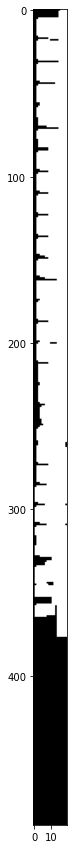

In [62]:
kernel = np.ones((5,5),np.uint8)
ROI_bar = cv2.Canny(ROI.copy() , 10, 255)
ROI_bar = cv2.dilate(ROI_bar, kernel, iterations = 1)
#ROI_bar = cv2.erode(ROI_bar, kernel, iterations = 5)
#ROI_bar = ROI.copy()
plt.imshow(ROI_bar,cmap='gray')

In [63]:
templateCnts = cv2.findContours(ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
templateCnts = imutils.grab_contours(templateCnts)
templateCnts = contours.sort_contours(templateCnts, method="left-to-right")[0]

In [64]:
len(templateCnts)

1

In [70]:
bb_heights = []
for (i, c) in enumerate(templateCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    bb_heights.append(h)

visible_gauge = max(bb_heights)
print(visible_gauge)

377


Now that we have a length of the visible staff gauge text and markers, we can subtract that length from the total length of the staff gauge with no snow prensent, and divide by the number of pixels per meter to find meters of snow!

In [71]:
(gauge_height - visible_gauge)/gauge_height*200

46.12244897959184